In [41]:
import torch


# M4

In [25]:
"""
M4 DATASET

download manualy from kaggle and unpack
hourly data contains 245 timeseries with 960 datapoint and
260 timeseries with 169 nans at the end --> 700 datapoints


we load hourly train and test data for m4
- train is shortened to 700 to remove NANs
- some timeseries are removed for electricity prediction to 348 / training for electricity
- test does not contain NANs
- test timeseries are tropped to fit the same 348 model
- TODO maybe still need to transpose
"""
import pandas as pd
kaggle_m4_link = "https://www.kaggle.com/datasets/yogesh94/m4-forecasting-competition-dataset"

m4_hourly_train = pd.read_csv("/home/ben_ten/ben/MA/datasets/m4/Hourly-train.csv")
m4_hourly_test = pd.read_csv("/home/ben_ten/ben/MA/datasets/m4/Hourly-test.csv")

m4_hourly_no_nan_train = m4_hourly_train.iloc[:349, :701]
m4_hourly_no_nan_test = m4_hourly_test.iloc[:349, :]

# Grid electricity

In [26]:
"""
Electric grid system dataset
paper : file:///C:/Users/Benedikt/Desktop/Mein_Ordner/WI-INFO/Semester_6/MA/s41597-022-01455-7.pdf
github : https://github.com/tamu-engineering-research/Open-source-power-dataset/tree/main
- use Deep NN with minute input, this is too small

"""

'\nElectric grid system dataset\npaper = file:///C:/Users/Benedikt/Desktop/Mein_Ordner/WI-INFO/Semester_6/MA/s41597-022-01455-7.pdf\n- use Deep NN with minute input, this is too small\n- only pre-normalized values, does not work for my research\n\n'

In [2]:
import pandas as pd

file= "/vol/fob-vol7/nebenf21/reinbene/bene/MA/data/grid_electricity/PSML/Minute-level Load and Renewable/CAISO_zone_1_.csv"

df = pd.read_csv(file)
df

,time,load_power,wind_power,solar_power,DHI,DNI,GHI,Dew Point,Solar Zenith Angle,Wind Speed,Relative Humidity,Temperature
0,2018-01-01 00:00:00,0.785327,0.004276,0.0,0.0,0.0,0.0,-7.7,168.880,1.2,23.78,12.5
1,2018-01-01 00:01:00,0.784770,0.004346,0.0,0.0,0.0,0.0,-7.7,168.842,1.2,23.78,12.5
2,2018-01-01 00:02:00,0.784213,0.004416,0.0,0.0,0.0,0.0,-7.7,168.804,1.2,23.78,12.5
3,2018-01-01 00:03:00,0.783657,0.004486,0.0,0.0,0.0,0.0,-7.7,168.766,1.2,23.78,12.5
4,2018-01-01 00:04:00,0.783100,0.004556,0.0,0.0,0.0,0.0,-7.7,168.728,1.2,23.78,12.5
...,...,...,...,...,...,...,...,...,...,...,...,...
1573918,2020-12-30 23:56:00,0.847004,0.002288,0.0,0.0,0.0,0.0,-7.8,169.010,0.8,29.40,9.2
1573919,2020-12-30 23:57:00,0.846690,0.002437,0.0,0.0,0.0,0.0,-7.8,168.990,0.8,29.40,9.2
1573920,2020-12-30 23:58:00,0.846377,0.002587,0.0,0.0,0.0,0.0,-7.8,168.970,0.8,29.40,9.2
1573921,2020-12-30 23:59:00,0.846063,0.002736,0.0,0.0,0.0,0.0,-7.8,168.950,0.8,29.40,9.2


# europre elecrticity

/home/ben_ten/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


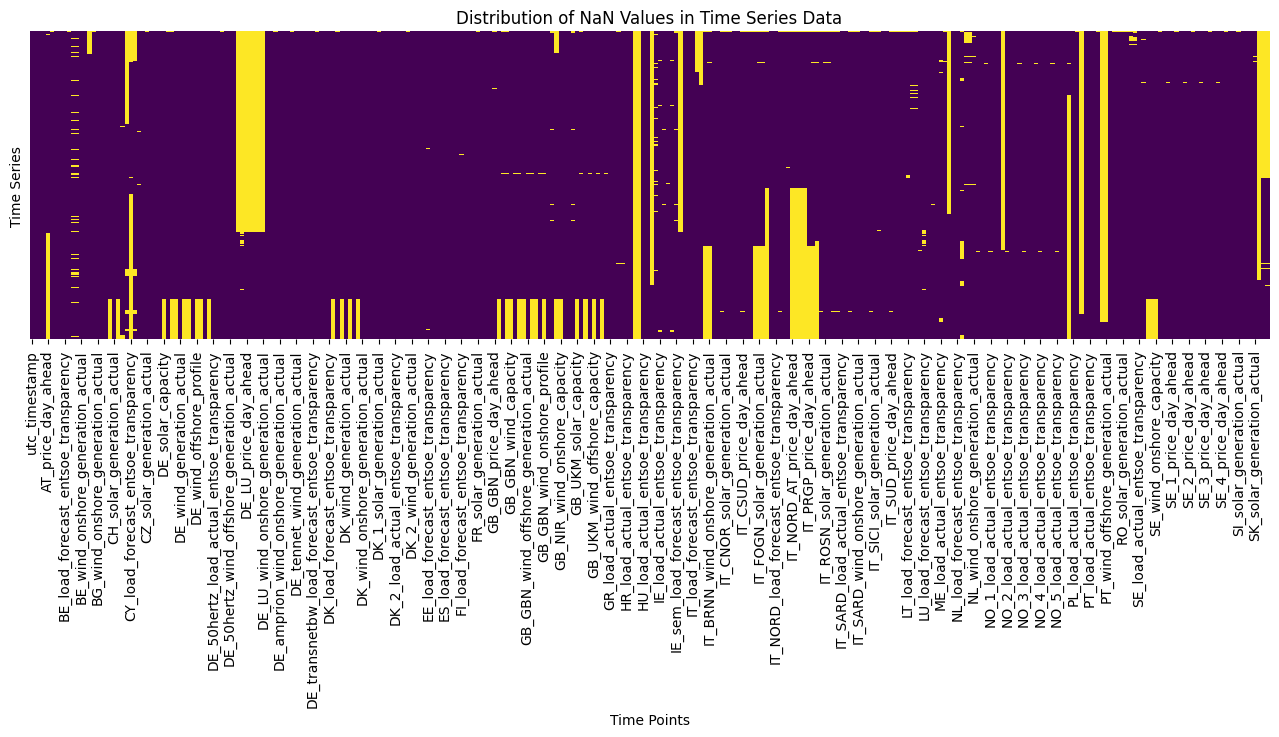

In [1]:
"""
europe electricity data
jupyterNB for explanation: https://nbviewer.org/github/Open-Power-System-Data/datapackage_timeseries/blob/2020-10-06/main.ipynb
- 50k entries
- 300 variates
- countries have different variates as some dont have wind/offshore or some NANs

"""
import config
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import data_handling, helpers
import random
import matplotlib.pyplot as plt

df = pd.read_csv(config.CONFIG_DATA["eu_electricity"] / ".csv")
print(df.head())
def visualize_nans(df):
	# Create a heatmap to visualize the distribution of NaN values after removing some
	nan_counts = df.isna().sum()

	plt.figure(figsize=(16, 4))
	sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
	plt.xlabel('Time Points')
	plt.ylabel('Time Series')
	plt.title('Distribution of NaN Values in Time Series Data')
	plt.show()
visualize_nans(df)

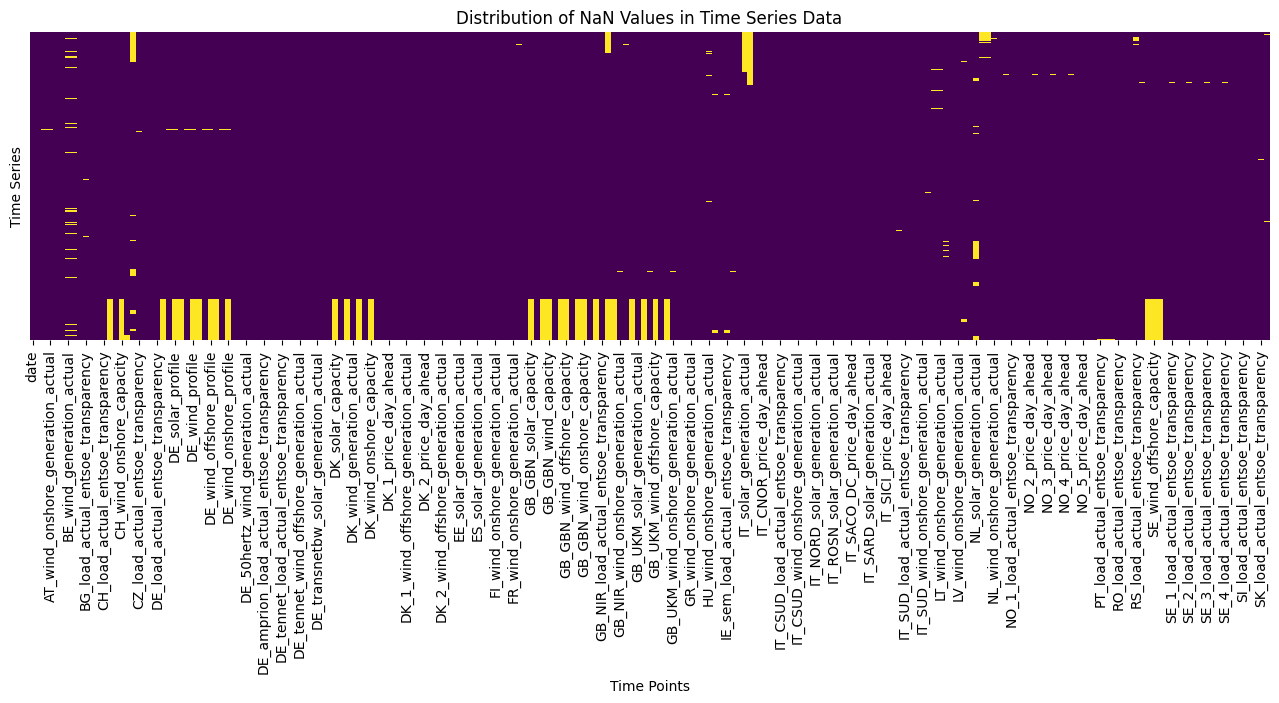

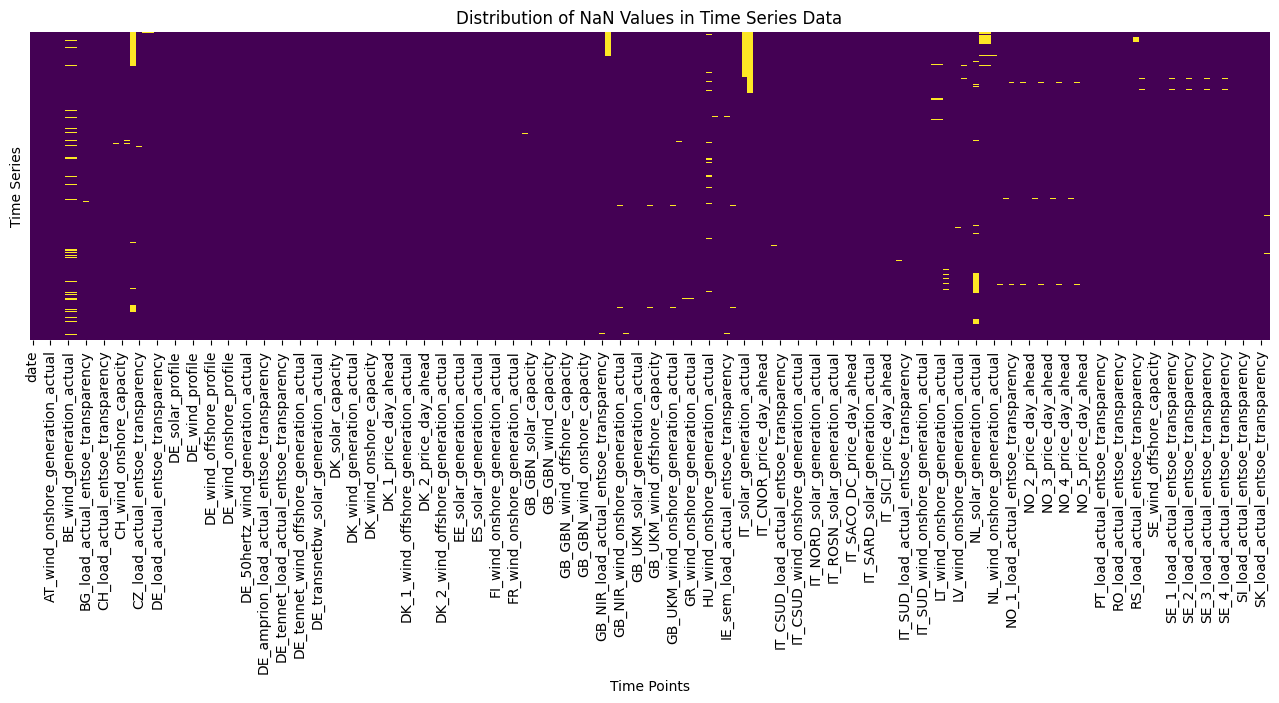

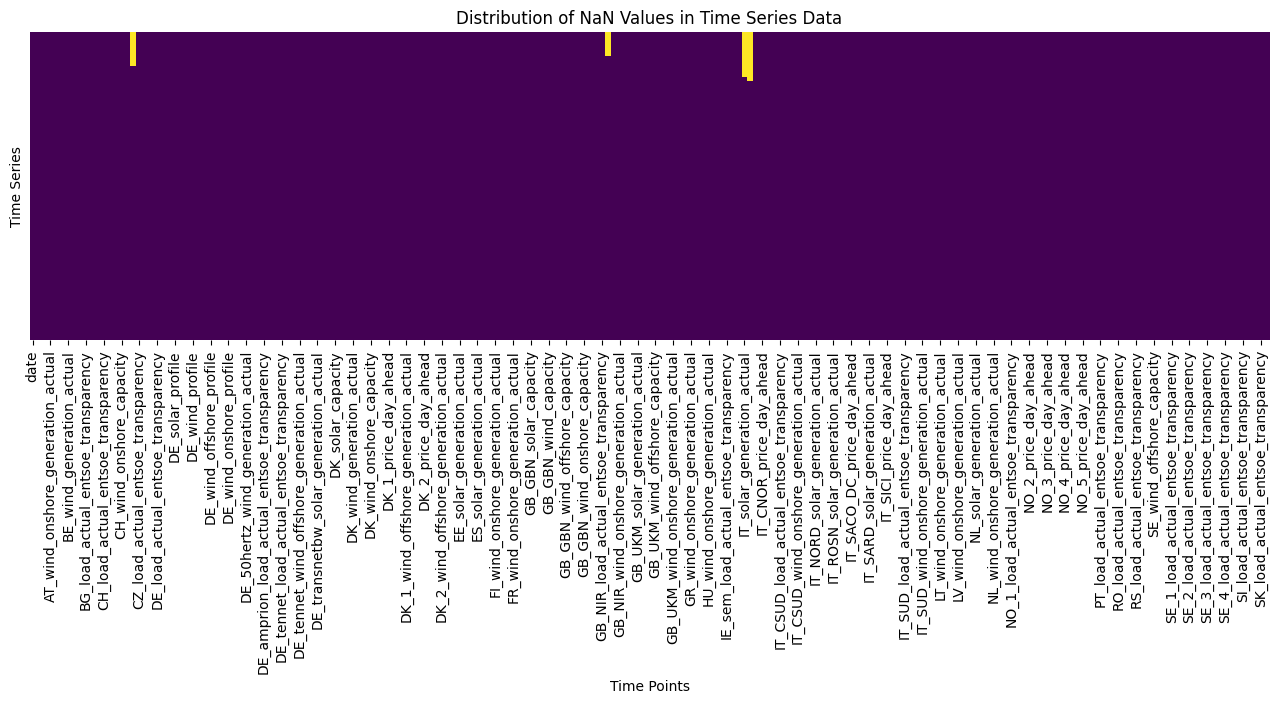

In [3]:
# drop second timestamp column
df = df.drop('cet_cest_timestamp', axis=1)

# rename to fit DataSetClass
df.rename(columns={'utc_timestamp': 'date'}, inplace=True)


# drop forecast because its synthetic data
columns_to_delete = ['forecast']
df = df.drop([col for col in df.columns if any(partial_name in col for partial_name in columns_to_delete)], axis=1)

# drop columns with more than 40% missing values
threshold = 0.3 * len(df)
columns_to_drop = df.columns[df.isna().sum() > threshold]
df = df.drop(columns=columns_to_drop)
visualize_nans(df)

# drop rows with more than 10% NANs
threshold = 0.05 * len(df.columns)
df = df[df.isna().sum(axis=1) <= threshold]
visualize_nans(df)

# forward fill if previous values are present
df = df.fillna(method='ffill')
visualize_nans(df)

# values at the start are set to zero, no more NANs
df = df.fillna(0)

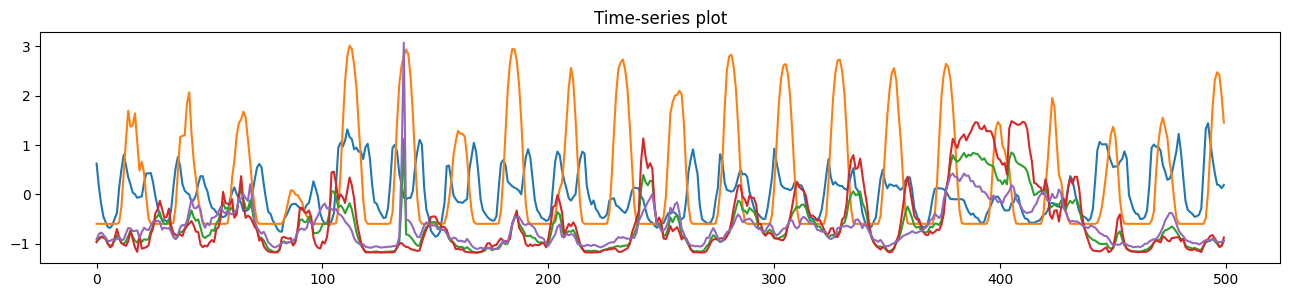

In [1]:
# sanity check if conversion worked correctly
# select 5 random time-series and 500 datapoints each
data_tensor = data_handling.eu_electricity_to_tensor()
data_dict, standardize_values =  data_handling.train_test_split_eu_elec(data_tensor, standardize=True)
train_tensor = data_dict["train"]

time_id = random.randint(0, train_tensor.size(0)-500)
ids = random.randint(0, train_tensor.size(1)-5)

numpy_array = train_tensor[time_id : time_id+500 , ids : ids+5].numpy()

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(16, 3))
plt.plot(numpy_array)
plt.title("Time-series plot")
plt.show()

# electricity

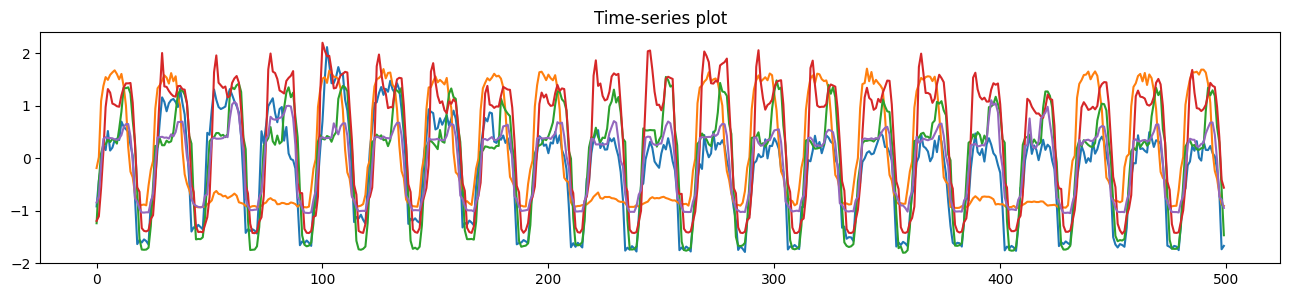

In [3]:
import pandas
from utils import data_handling, helpers
import random
import matplotlib.pyplot as plt

# sanity check if conversion worked correctly
# select 5 random time-series and 500 datapoints each
electricity_dict = data_handling.load_electricity()
train_tensor = electricity_dict["electricity_train"]

time_id = random.randint(0, train_tensor.size(0)-500)
ids = random.randint(0, train_tensor.size(1)-5)

numpy_array = train_tensor[time_id : time_id+500 , ids : ids+5].numpy()

# Plot the NumPy array using Matplotlib
plt.figure(figsize=(16, 3))
plt.plot(numpy_array)
plt.title("Time-series plot")
plt.show()

# electricity load southern germany

https://data.open-power-system-data.org/household_data/

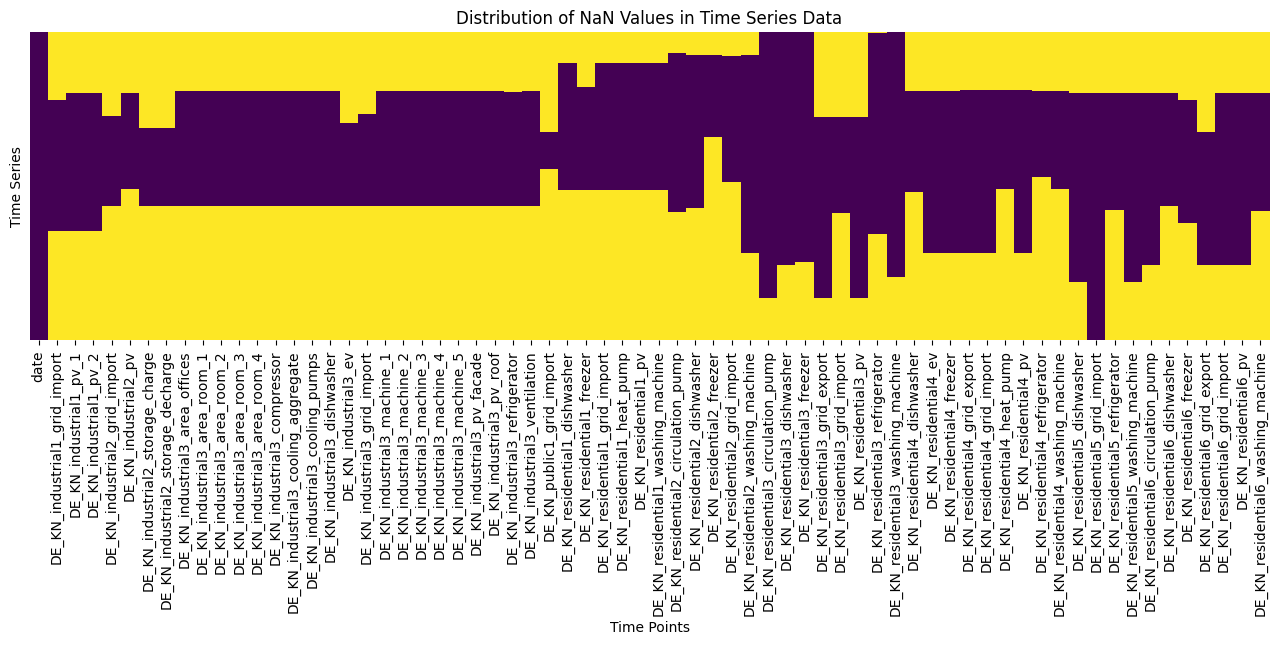

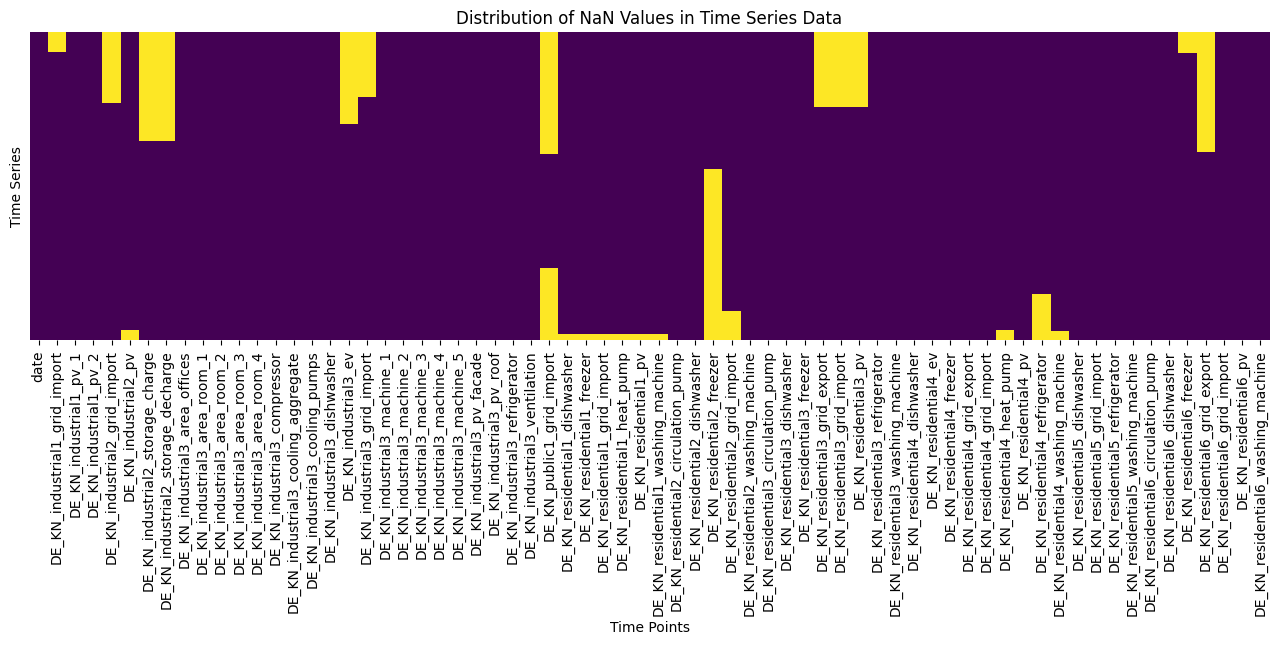

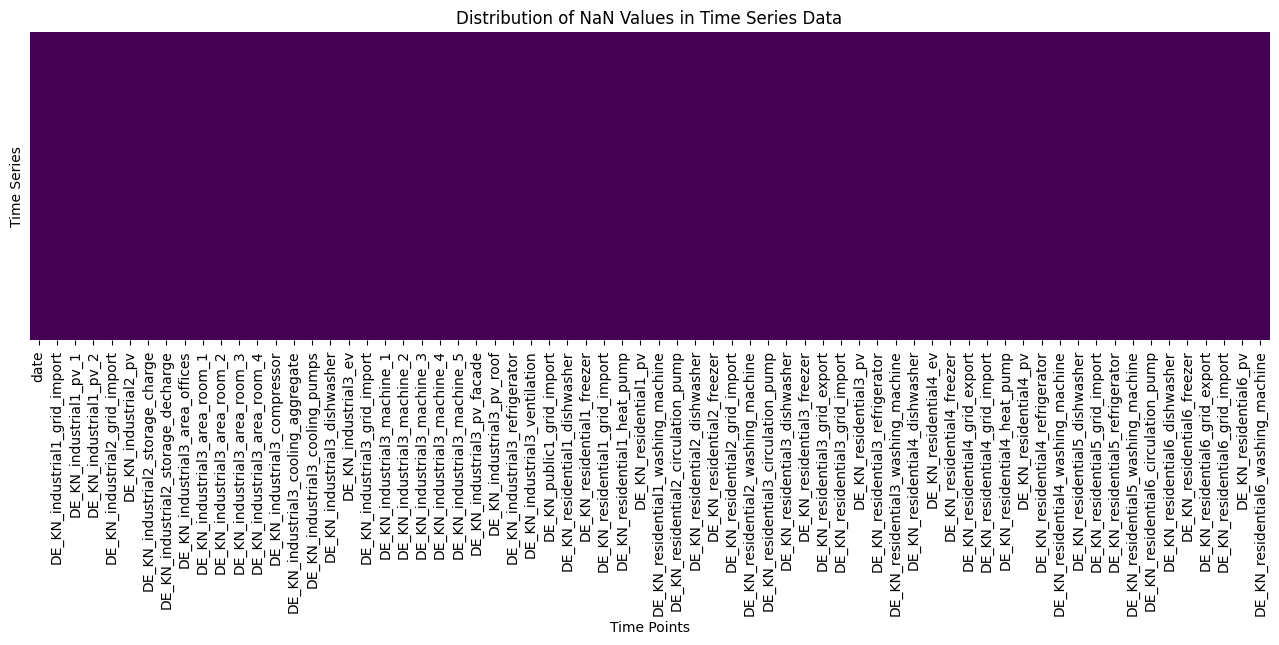

,date,DE_KN_industrial1_grid_import,DE_KN_industrial1_pv_1,DE_KN_industrial1_pv_2,DE_KN_industrial2_grid_import,DE_KN_industrial2_pv,DE_KN_industrial2_storage_charge,DE_KN_industrial2_storage_decharge,DE_KN_industrial3_area_offices,DE_KN_industrial3_area_room_1,...,DE_KN_residential5_grid_import,DE_KN_residential5_refrigerator,DE_KN_residential5_washing_machine,DE_KN_residential6_circulation_pump,DE_KN_residential6_dishwasher,DE_KN_residential6_freezer,DE_KN_residential6_grid_export,DE_KN_residential6_grid_import,DE_KN_residential6_pv,DE_KN_residential6_washing_machine
7650,2015-10-26 11:00:00+00:00,0.000,22.870,12.595,0.000,93.764,0.000,0.000,332.163,108.218,...,0.045,0.000,0.000,1.967,0.003,0.000,0.00,24.250,26.510,0.367
7651,2015-10-26 12:00:00+00:00,0.000,23.510,13.120,0.000,95.944,0.000,0.000,334.673,109.226,...,0.395,0.071,0.148,1.995,0.003,0.000,0.00,24.710,27.445,0.371
7652,2015-10-26 13:00:00+00:00,0.000,25.020,13.725,0.000,102.879,0.000,0.000,337.428,110.723,...,0.865,0.082,0.488,2.075,0.003,0.000,0.00,25.275,32.410,0.465
7653,2015-10-26 14:00:00+00:00,0.000,25.930,14.165,0.000,107.035,0.000,0.000,339.948,112.066,...,1.085,0.126,0.575,2.173,0.003,0.000,0.00,25.885,36.145,0.501
7654,2015-10-26 15:00:00+00:00,0.000,26.214,14.240,0.000,109.126,0.000,0.000,342.143,113.218,...,1.325,0.184,0.670,2.219,0.003,0.000,0.00,26.480,37.190,0.501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19958,2017-03-22 07:00:00+00:00,309125.320,6065.362,4739.053,14803.793,22122.400,1225.614,737.186,14351.049,5322.478,...,3931.326,501.786,257.443,532.791,86.699,126.872,1570.85,5192.824,10656.152,66.570
19959,2017-03-22 08:00:00+00:00,309152.242,6065.690,4739.226,14806.113,22122.400,1225.634,737.186,14353.349,5324.654,...,3931.991,501.789,257.678,532.818,86.700,126.874,1570.86,5192.834,10656.566,66.570
19960,2017-03-22 09:00:00+00:00,309185.273,6066.045,4739.459,14808.654,22122.400,1225.653,737.186,14355.649,5326.713,...,3932.316,501.854,257.679,532.849,86.700,126.877,1570.88,5192.854,10657.141,66.570
19961,2017-03-22 10:00:00+00:00,309226.992,6066.410,4739.726,14810.605,22122.400,1225.674,737.186,14358.109,5328.808,...,3932.931,501.907,257.767,532.877,86.700,126.892,1570.90,5192.874,10657.785,66.570


In [39]:
def visualize_nans(df):
	# Create a heatmap to visualize the distribution of NaN values after removing some
	nan_counts = df.isna().sum()

	plt.figure(figsize=(16, 4))
	sns.heatmap(df.isna(), cmap='viridis', cbar=False, yticklabels=False)
	plt.xlabel('Time Points')
	plt.ylabel('Time Series')
	plt.title('Distribution of NaN Values in Time Series Data')
	plt.show()

path = "/home/ben_ten/ben/MA/datasets/household_south_germany_hourly/household_data_60min_singleindex.csv"
df = pd.read_csv(path)

# drop second timestamp column
df = df.drop('cet_cest_timestamp', axis=1)
df = df.drop('interpolated', axis=1)

# rename to fit DataSetClass
df.rename(columns={'utc_timestamp': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])



# drop columns with more than 90% missing values
threshold = 0.9 * len(df)
columns_to_drop = df.columns[df.isna().sum() > threshold]
df = df.drop(columns=columns_to_drop)
visualize_nans(df)

# drop rows with more than 10% NANs
threshold = 0.20 * len(df.columns)
df = df[df.isna().sum(axis=1) <= threshold]
visualize_nans(df)

# forward fill if previous values are present
df = df.fillna(method='ffill')

# values at the start are set to zero, no more NANs
df = df.fillna(0)

visualize_nans(df)

df

In [40]:
# Sort the DataFrame based on the 'date' column
df = df.sort_values(by='date')

# Define the split sizes - these values can be changed according to your needs
train_size = 0.7
val_size = 0.10
test_size = 0.20

# Calculate the indices for the split
train_index = int(len(df) * train_size)
val_index = train_index + int(len(df) * val_size)

# Split the DataFrame
train = df[:train_index]
val = df[train_index:val_index]
test = df[val_index:]

In [42]:

# Assuming train, val, test are your pandas DataFrames

# Convert date column to a time step index (if needed)
# For simplicity, let's assume we drop the date column and use the DataFrame index as the time step
train = train.drop(columns=['date'])
val = val.drop(columns=['date'])
test = test.drop(columns=['date'])

# Convert the DataFrames to 2D arrays
train_array = train.values
val_array = val.values
test_array = test.values

In [43]:
# Convert the arrays to tensors
train_tensor = torch.tensor(train_array, dtype=torch.float32)
val_tensor = torch.tensor(val_array, dtype=torch.float32)
test_tensor = torch.tensor(test_array, dtype=torch.float32)

# Now you have your tensors
# Check if they have the correct shape: (time_series x id)
print(train_tensor.shape)
print(val_tensor.shape)
print(test_tensor.shape)

torch.Size([8619, 67])
torch.Size([1231, 67])
torch.Size([2463, 67])
